# Kolkata Housing Price Analysis & Prediction

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [5]:

kolkata = pd.read_csv('/content/Kolkata.csv')

In [6]:
kolkata.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,2235000,1016,Barasat,3,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,3665999,1111,Keshtopur,2,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3774000,1020,Rajarhat,2,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2524000,935,Narendrapur,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,8300000,1956,New Town,3,1,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0


In [7]:
kolkata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6507 entries, 0 to 6506
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Price                6507 non-null   int64 
 1   Area                 6507 non-null   int64 
 2   Location             6507 non-null   object
 3   No. of Bedrooms      6507 non-null   int64 
 4   Resale               6507 non-null   int64 
 5   MaintenanceStaff     6507 non-null   int64 
 6   Gymnasium            6507 non-null   int64 
 7   SwimmingPool         6507 non-null   int64 
 8   LandscapedGardens    6507 non-null   int64 
 9   JoggingTrack         6507 non-null   int64 
 10  RainWaterHarvesting  6507 non-null   int64 
 11  IndoorGames          6507 non-null   int64 
 12  ShoppingMall         6507 non-null   int64 
 13  Intercom             6507 non-null   int64 
 14  SportsFacility       6507 non-null   int64 
 15  ATM                  6507 non-null   int64 
 16  ClubHo

In [8]:
len(kolkata)

6507

This dataset is already available on Kaggle in cleaned up form and we can see there are no missing values in any of the columns. (6507/6507 for all features). We also see that there are close to 40 potential features that can determine the price of the apartment. Except for 'Area', 'Location' and 'No. of Bedrooms' all other features are Boolean type, i.e. either present or not present. We do not have any ordinal features (such as good/average or old/new etc in this case).

A key metric in the housing industry, at least in India, is <b>"Price Per Square Feet (Price/Area)"</b>, expressed as Rupees Per Square Feet (Rupee being our currency). Almost everyone uses this metric to compare the prices as it eliminates the impact of house size and provides an apple to apple comparison. Let us add a column that captures Price Per Square Feet. We will call this <b>"PricePSF"</b> in short

In [9]:
kolkata['PricePSF'] = kolkata['Price'] / kolkata['Area']

Let us check the distribution of the non-boolean and non-string elements of our data

<ipython-input-10-f18dddf9e80a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(kolkata[feature], color=color)
<ipython-input-10-f18dddf9e80a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(kolkata[feature], color=color)
<ipython-input-10-f18dddf9e80a>:6: UserWarning: 

`distplot` is a deprec

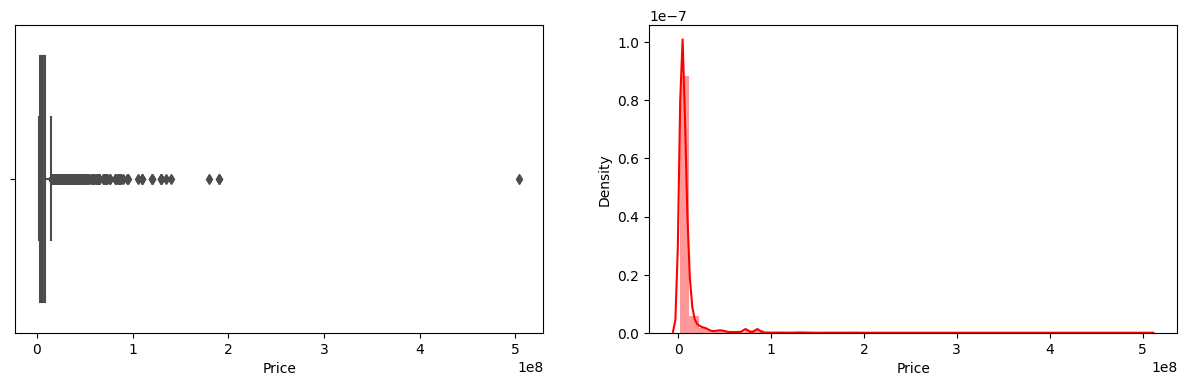

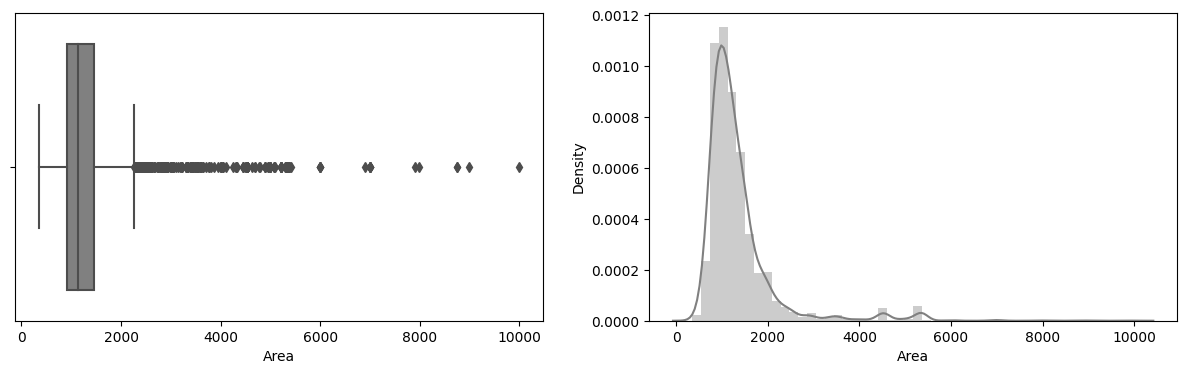

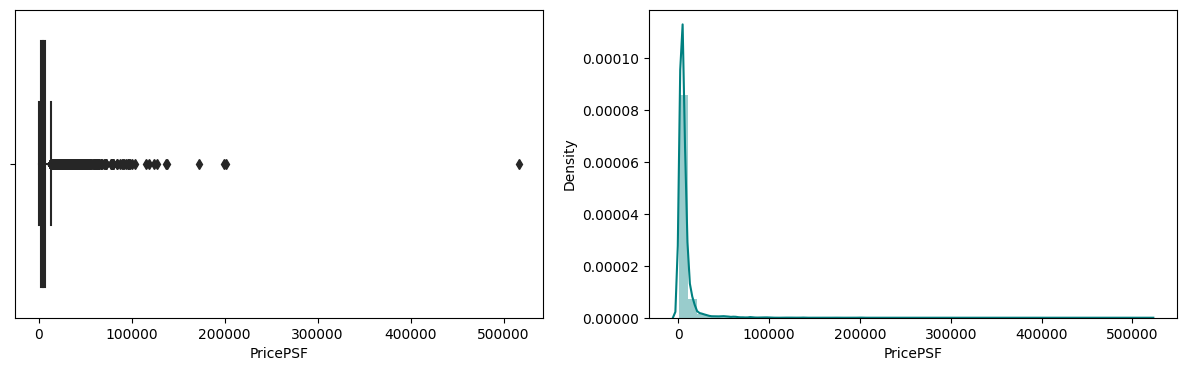

In [10]:
def dist_plot (feature, color, position=121):
    plt.figure(figsize=(15,4))
    plt.subplot(position)
    sns.boxplot(x=feature, data=kolkata, color=color)
    plt.subplot(position+1)
    sns.distplot(kolkata[feature], color=color)
dist_plot('Price', 'red')
dist_plot('Area', 'grey')
dist_plot('PricePSF', 'teal')

As we can see above, the data is <b>heavily right-skewed</b> for Price and Area both. One would expect that PricePSF would be normally distributed as it is a ratio, however it is not so. This indicates either or both of the following:

1. There is much more skewness in Price compared to Area
2. The houses with high Prices are not necessarily the ones with the large Area, hence PricePSF is not able to normalize such cases

We now proceed to <b>remove outliers</b> so that they don't have a lopsided impact on our model. As the data is heavily right skewed, we remove a higher percentile (10%) from the top versus bottom(5%)

In [11]:
# define outliers
price_psf_outliers = np.percentile(kolkata.PricePSF, [5,90])
price_outliers = np.percentile(kolkata.Price, [5,90])
area_outliers = np.percentile(kolkata.Area, [5,90])
# create filters based on outliers
price_psf_filter = (kolkata.PricePSF > price_psf_outliers[0]) & (kolkata.PricePSF < price_psf_outliers[1])
price_filter = (kolkata.Price > price_outliers[0]) & (kolkata.Price < price_outliers[1])
area_filter = (kolkata.Area > area_outliers[0]) & (kolkata.Area < area_outliers[1])
# apply filters
bangalore = kolkata[(price_psf_filter) & (price_filter) & (area_filter)]

Let us check the distribution again

<ipython-input-10-f18dddf9e80a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(kolkata[feature], color=color)
<ipython-input-10-f18dddf9e80a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(kolkata[feature], color=color)
<ipython-input-10-f18dddf9e80a>:6: UserWarning: 

`distplot` is a deprec

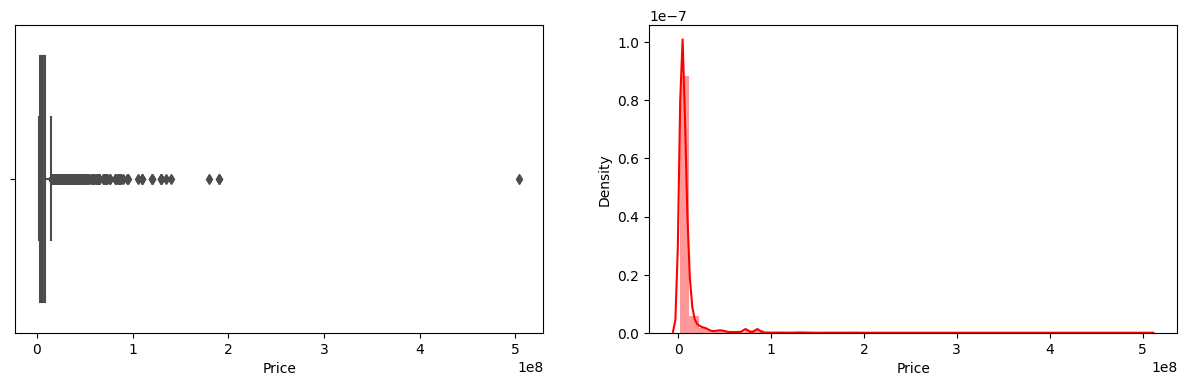

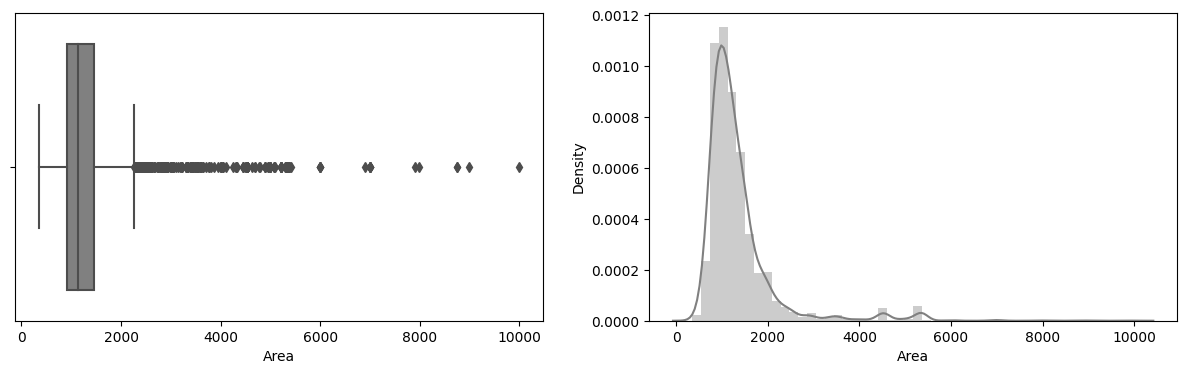

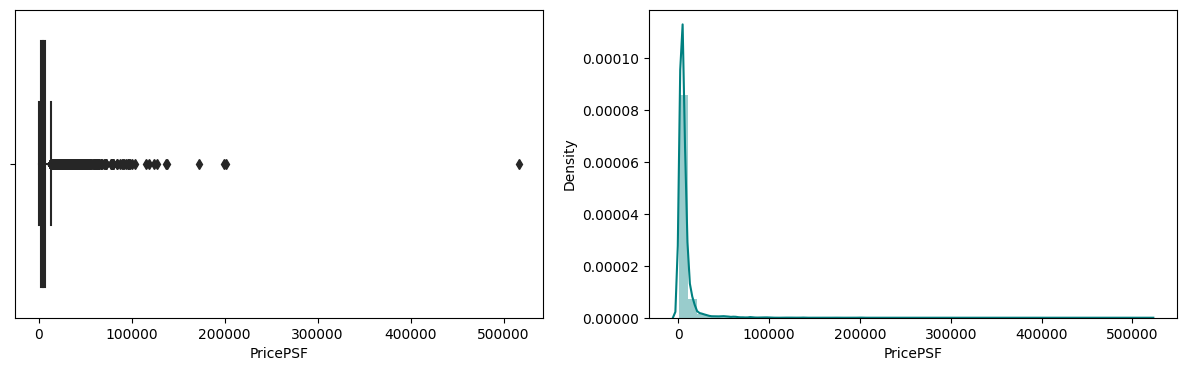

In [12]:
dist_plot('Price', 'red')
dist_plot('Area', 'grey')
dist_plot('PricePSF', 'teal')

The above distributions looks far better. Though there is still right-skewnesss, we can expect this from real estate prices as a small number of large size and expensive properties will pull the distribution to the right.

<h3>Let us briefly discuss what drives a house price (longish read but important):</h3>

1. Area - Larger, would logically mean more expensive, all else held constant
2. Location - Factoring this requires knowledge of local area. We will try a workaround for this
3. Amenities - This is tricky. High rise apartment complexes will have lot of amenities compared to independent houses and villas. Yet they may be cheaper because all these amenities are shared. In the subsequent sections I have tried to create a 'FeatureScore' for amenities (higher FeatureScore should imply higher Price). However I admit that independent houses may lose out on this and the model may underprice such houses. I would welcome inputs on how to tackle this.
4. Floor rise - In high rise complexes in India, houses on higher floors are priced higher by a linear formula. Floor data is absent from the data set.
5. Developer Reputation - Again this is very important in India. Two apartments in the same Location by developers of different repute have markedly different PricePSF. This information is absent from the data set. Even if it was available, one would require some local knowledge to factor in developer score.
6. Resale or not - Another tricky one. In absence of the age of the house, only a Resale binary may not produce accurate results. A one year old resale versus 20 year old are very different. In some cases a 3-4 year resale may fetch a higher PricePSF as the complex would have matured and be niggle free, better landscaped etc.

<h3>As we can see, quite a few important variables are not available in the data set, hence our model may not perform very well on the test set</h3>

Let us now check the features available to us and also clean up the names so that they do not cause any problems later

In [13]:
kolkata.columns

Index(['Price', 'Area', 'Location', 'No. of Bedrooms', 'Resale',
       'MaintenanceStaff', 'Gymnasium', 'SwimmingPool', 'LandscapedGardens',
       'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames', 'ShoppingMall',
       'Intercom', 'SportsFacility', 'ATM', 'ClubHouse', 'School',
       '24X7Security', 'PowerBackup', 'CarParking', 'StaffQuarter',
       'Cafeteria', 'MultipurposeRoom', 'Hospital', 'WashingMachine',
       'Gasconnection', 'AC', 'Wifi', 'Children'splayarea', 'LiftAvailable',
       'BED', 'VaastuCompliant', 'Microwave', 'GolfCourse', 'TV',
       'DiningTable', 'Sofa', 'Wardrobe', 'Refrigerator', 'PricePSF'],
      dtype='object')

Two columns seem to have problematic names. Let's rename them

In [14]:
kolkata.rename(columns={'No. of Bedrooms':'Bedrooms', "Children'splayarea":'PlayArea'}, inplace=True)

As we can see from the columns list, there are a lot of features, most of them binary. Most of the binary features will fit under the broad category of <b>Amenities</b>. In the following section I have tried to calculate feature scores for each house bases on the Amenities being absent or present.

<b><u>Note: Important</u></b> - I have assigned weights to binary features based on my discretion. You are free to use the weights you want. I have also used a scale of 0-4 (0 being least important and 4 being most important). Again the choice of this scale is entirely up to you.

In [15]:
# assign weights to features
feature_dict = {'MaintenanceStaff':2, 'Gymnasium':4, 'SwimmingPool':4,'LandscapedGardens':3, 'JoggingTrack':3, 'RainWaterHarvesting':2,'IndoorGames':3, 'ShoppingMall':2, 'Intercom':2, 'SportsFacility':3, 'ATM':2, 'ClubHouse':2, 'School':2, '24X7Security':1, 'PowerBackup':4, 'CarParking':3, 'StaffQuarter':0, 'Cafeteria':0, 'MultipurposeRoom':2, 'Hospital':3, 'WashingMachine':0, 'Gasconnection':2, 'AC':0, 'Wifi':0, 'PlayArea':3, 'LiftAvailable':0, 'BED':0, 'VaastuCompliant':0, 'Microwave':0, 'GolfCourse':0, 'TV':0, 'DiningTable':0, 'Sofa':0, 'Wardrobe':0, 'Refrigerator':0}

In [16]:
# convert to Dataframe
features = pd.DataFrame(feature_dict.items(), columns=['Features', 'Weight'])

In [17]:
features.head()

,Features,Weight
0,MaintenanceStaff,2
1,Gymnasium,4
2,SwimmingPool,4
3,LandscapedGardens,3
4,JoggingTrack,3


In [18]:
# The features matrix has 35 features
features.shape

(35, 2)

To arrive at Feature Score for each house, we need to calculate dot product between the features matrix and the features binaries. Before this, we need to <b><u>subset a features matrix</u></b> from the kolkata dataset

In [19]:
features_matrix = kolkata[['MaintenanceStaff', 'Gymnasium', 'SwimmingPool',
       'LandscapedGardens', 'JoggingTrack', 'RainWaterHarvesting',
       'IndoorGames', 'ShoppingMall', 'Intercom', 'SportsFacility', 'ATM',
       'ClubHouse', 'School', '24X7Security', 'PowerBackup', 'CarParking',
       'StaffQuarter', 'Cafeteria', 'MultipurposeRoom', 'Hospital',
       'WashingMachine', 'Gasconnection', 'AC', 'Wifi', 'PlayArea',
       'LiftAvailable', 'BED', 'VaastuCompliant', 'Microwave',
       'GolfCourse', 'TV', 'DiningTable', 'Sofa', 'Wardrobe',
       'Refrigerator']]

In [20]:
features_matrix.tail()

,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
6502,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6503,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6504,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6505,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6506,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


Some examination (not shown here) revelas that the features matrix contains (0, 1, 9) as values. I would assume that 9 represents NaN. Let us replace all 9s by 0s

In [21]:
features_matrix.replace(9, 0, inplace=True)

<ipython-input-21-e3e9540d43cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_matrix.replace(9, 0, inplace=True)


In [22]:
features_matrix.shape

(6507, 35)

We will now compute <b>dot product</b> between the "features_matrix" <b>(shape = 4453 x 35)</b> and 'Weight' column of the "features" dataframe <b>(shape = 35 x 1)</b>. This will result in a column vector of shape <b>4453 x 1</b> and is nothing but the FeatureScore for each house. We will then join this resulting vector with the kolkata dataframe

In [23]:
# apply dot product to compute feature score for every row
feature_scores_df = np.dot(features_matrix, features['Weight'])

In [24]:
# join feature scores column with kolkata dataframe
kolkata['FeatureScore'] = feature_scores_df

In [25]:
kolkata.head(3)

,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore
0,2235000,1016,Barasat,3,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,2199.803150,27
1,3665999,1111,Keshtopur,2,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,3299.729073,22
2,3774000,1020,Rajarhat,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3700.000000,9


We have now reduced the number of features on which to run our regression model. These are:

1. Area (numeric)
2. Location (string). In next section I will propose a way to tackle this.
3. Bedrooms (numeric)
4. Feature Score (numeric)
4. Resale (boolean)

<b>Before we proceed let us check if our numerical features have any colinearity</b>

<Axes: >

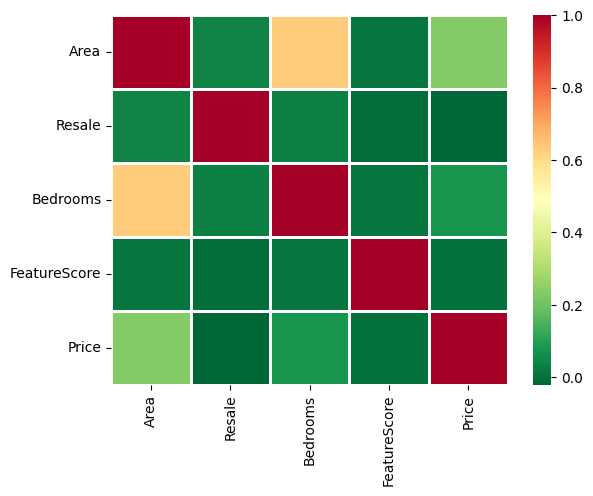

In [26]:
corr_df = kolkata[['Area', 'Resale', 'Bedrooms', 'FeatureScore', 'Price']]
sns.heatmap(corr_df.corr(method='pearson'), cmap='RdYlGn_r', linewidths=2)

<h3>Observations</h3>

1. We can see that <b>Area and Bedrooms are somewhat correlated</b>. This is not surprising as houses with larger area will tend to have more bedrooms and vice versa.
2. Area has a stronger correlation with Price compared to Bedrooms. If forced to make a choice, we should drop bedrooms to avoid colinearity
3. Interestingly FeatureScore does not seem to be correlated to Price. However, remember that the feature weights were my arbitrary choice and may be wrong. An industry expert can help here. For this analysis we will retain FeatureScore in our model

<h3>Let us now explore how we can model Location as a numeric feature</h3>

In [27]:
# Create a pivot table of Locations with PricePSF as the value
location_pivot = pd.pivot_table(data=kolkata, index='Location', aggfunc='mean', values='PricePSF')

In [28]:
location_pivot

,PricePSF
Location,
Acharya Jagadish Chandra Bose Road,7058.823529
Action Area I,3221.710722
Action Area I Newtown,3137.840611
Action Area II Newtown,6225.525856
Action Area IIB Newtown,5134.482759
...,...
purbalok,4865.384615
raghunathpur,6968.750000
salt lake sec iii,4541.771926


<b>Location is one of the most important determinants of house price</b>. I tried **One Hot Encoding** to factor locations, but with disastrous results as there were too many locations with few observations. As a bit of feature engineering, I am going to calculate the 'Location Premium' for every Location. This is nothing but the PricePSF for every location divided by the minimum PricePSF. This sets the cheapest location as the base location (with a score of 1) and every other location has a premium as a multiple of that base location

In [29]:
location_pivot['LocationPremium'] = location_pivot['PricePSF'] / location_pivot['PricePSF'].min()

In [30]:
location_pivot.sort_values('LocationPremium', ascending=False)

,PricePSF,LocationPremium
Location,,
Bedia Danga Kasba,59375.000000,122.120527
Mahamayatala,49922.727273,102.679406
Barrackpore,48678.101517,100.119501
Kalipark Kolkata,46567.164179,95.777796
Selimpur Lane,37487.179487,77.102385
...,...,...
Rabindra Sarovar,1804.201681,3.710822
Sodepur Road,1454.545455,2.991661
Kayastopara,1372.549020,2.823013


We now merge the location pivot with the kolkata dataframe on 'Location' column

In [31]:
kolkata = pd.merge(kolkata, location_pivot['LocationPremium'], on='Location')

As a final step we calculate the <b>log</b> of LocationPremium. I observed that it yields better results than simply using LocationPremium

In [32]:
kolkata['LogPremium'] = np.log(kolkata['LocationPremium'])

In [33]:
# check if all required columns are present
kolkata.head(3)

,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore,LocationPremium,LogPremium
0,2235000,1016,Barasat,3,0,0,1,1,1,1,...,0,0,0,0,0,0,2199.803150,27,6.327936,1.844974
1,2235000,1016,Barasat,3,0,0,1,1,1,1,...,0,0,0,0,0,0,2199.803150,27,6.327936,1.844974
2,3200000,1200,Barasat,3,0,0,0,0,0,0,...,0,0,0,0,0,0,2666.666667,0,6.327936,1.844974


<b>We are now ready to prepare our Linear Regression Model</b>

In [34]:
x = kolkata[['Area', 'FeatureScore', 'Resale', 'LogPremium', 'Bedrooms']]
y = kolkata['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=19)

<b>I used Statsmodel to run the regression as it yields a useful summary which is not provided by ScikitLearn</b>

In [35]:
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.303
Model:                            OLS   Adj. R-squared (uncentered):              0.303
Method:                 Least Squares   F-statistic:                              452.6
Date:                Mon, 19 Jun 2023   Prob (F-statistic):                        0.00
Time:                        06:02:20   Log-Likelihood:                         -93124.
No. Observations:                5205   AIC:                                  1.863e+05
Df Residuals:                    5200   BIC:                                  1.863e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Area          5474.4776    316.289     17.308      0.000    4854.418    6094.538
FeatureScore -2.926e+04   7.57e+04     -0.386      0.699   -1.78e+05    1.19e+05
Resale         -9.4e+05   4.24e+05     -2.217      0.027   -1.77e+06   -1.09e+05
LogPremium    4.157e+06   2.71e+05     15.356      0.000    3.63e+06    4.69e+06
Bedrooms     -3.481e+06   3.35e+05    -10.406      0.000   -4.14e+06   -2.83e+06
==============================================================================
Omnibus:                     8832.306   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17666390.822
Skew:                          11.209   Prob(JB):                         0.00
Kurtosis:                     287.528   Cond. No.                     3.37e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Observations</h3>

1. R squared value of 92.3% is good. However, we are yet to see how the model performs on test data
2. Feature Score has a p-value of greater than 0.05, indicating that it is not an important determinant of price. Either that or I have not engineered it well.
3. FeatureScore also has a very high range (even entering negative territory). Clearly there is much more to be engineered here as presence of even a single feature should not reduce the price of a house.
4. Bedrooms has a negative coefficient, indicating more bedrooms lower the price. This seems like an anomaly and is a likely result of colinearity between bedrooms and Area. If modeled in the absense of Area, Bedrooms may result in a positive correlation.
5. 'Resale = True' negatively impacts the price, which is understandable. However the extent (almost a million Rupees) may be a subject for further analysis for industry experts

<b>Let us now see how the model performs on test data</b>

Text(0, 0.5, 'Predicted Test Prices')

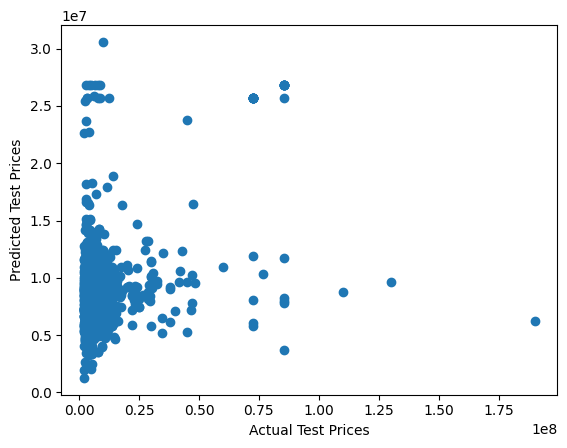

In [36]:
predictions = model.predict(x_test)
plt.scatter(x=y_test, y=predictions)
plt.xlabel('Actual Test Prices')
plt.ylabel('Predicted Test Prices')

Although there seems to be a linear correlation between test set Prices and predicted Prices, there is also a fair bit of scatter. Let us check the residuals plot

<ipython-input-37-1b676e3ddb97>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


Text(0.5, 0, 'Residuals')

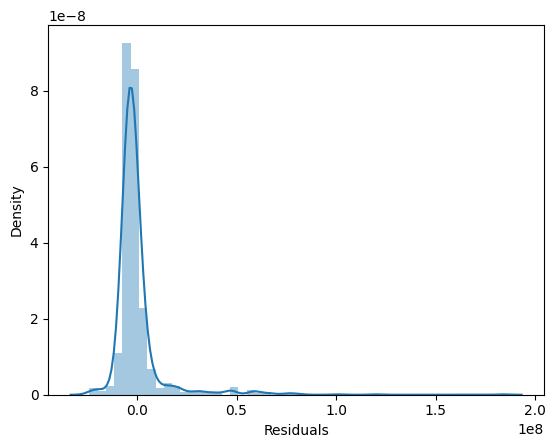

In [37]:
residuals = y_test - predictions
sns.distplot(residuals)
plt.xlabel('Residuals')

The residuals seem to be mostly normally distributed, except for a slight skew to the right. Residuals bordering on close to Rs 10 million are problematic. Let us now check the plot of residuals against predicted prices

Text(0, 0.5, 'Residuals')

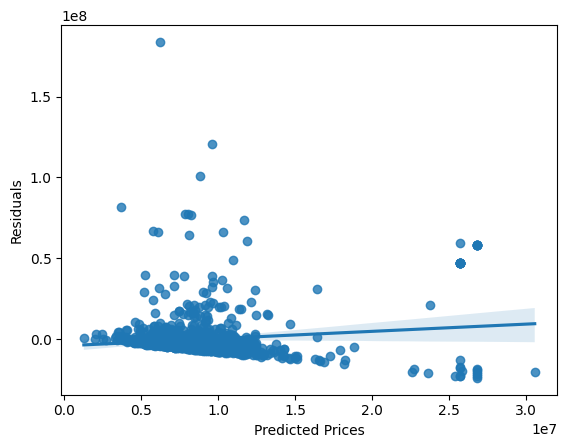

In [38]:
sns.regplot(x=predictions, y=residuals)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')

In [39]:
mean_absolute_error(y_test,predictions)

6209636.434220369

In [40]:
predictions.mean()

8785232.365842383

<h3>Observations</h3>

1. The residuals-predictions plot has a somewhat funnel/cone shape towards the right, indicating Heteroscadasticity. This is to be expected in housing prices as they do not vary uniformly. Houses which are very large or very small tend to be in short supply and hence command a higher PricePSF compared to commonly available sizes.
2. For higher prices our model makes larger errors. I had expected this
3. The residuals seem to be distributed almost equally on both sides of the straight line, indicating that our model over predicts and under predicts almost equally
4. Mean absolute error of Rupees 1.65 million looks high for a range of values which has a mean of Rs 7.64 million

Let us run our model once again, this time excluding Bedrooms as a predictor. Despite evidence against FeatureScore, I am retaining it as I am not fully convinced that features don't have an impact

In [41]:
x2 = kolkata[['Area', 'FeatureScore', 'Resale', 'LogPremium']]
y2 = kolkata['Price']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=19)

In [42]:
model2 = sm.OLS(y_train2, x_train2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.289
Model:                            OLS   Adj. R-squared (uncentered):              0.288
Method:                 Least Squares   F-statistic:                              527.8
Date:                Mon, 19 Jun 2023   Prob (F-statistic):                        0.00
Time:                        06:02:21   Log-Likelihood:                         -93178.
No. Observations:                5205   AIC:                                  1.864e+05
Df Residuals:                    5201   BIC:                                  1.864e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Area          3321.4658    241.685     13.743      0.000    2847.661    3795.271
FeatureScore -3.568e+04   7.65e+04     -0.467      0.641   -1.86e+05    1.14e+05
Resale       -1.193e+06   4.28e+05     -2.790      0.005   -2.03e+06   -3.55e+05
LogPremium    1.803e+06    1.5e+05     12.002      0.000    1.51e+06     2.1e+06
==============================================================================
Omnibus:                     8890.258   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17942400.500
Skew:                          11.371   Prob(JB):                         0.00
Kurtosis:                     289.730   Cond. No.                     3.37e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Observations</h3>

1. The R-squared value is almost unchanged, but what is important to see is that the coefficient for Area has reduced. I like this because to me this coefficient represents the cost of construction and it is now closer to the real value (the cost of construction in India varies from Rupees 2500-3500 per square feet). This should be similar for all houses regardless of area and the premium should actually be derived from the Location
2. The p-value of FeatureScore has increased, indicating it is even less important in this second model

<b>Let us make predictions using model2</b>

In [43]:
predictions2 = model2.predict(x_test2)

I am skipping the plots and only concerning myself with the mean squared error for the time being

In [44]:
mean_absolute_error(y_test2,predictions2)

6301104.95446526

In [45]:
predictions2.mean()

8815368.3718273

In [46]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import joblib

# Save the model as a pickle in a file
joblib.dump(model, 'model.pkl')

['model.pkl']

<h2>Concluding Remarks</h2>

1. Model2 does not seem to be performing better than Model1 on test data.
2. However, I do believe that Model2 does better than Model1 in assigning a lower coefficient to Area for reasons explained earlier
3. Also as noted earlier, significant drivers of Price such as Developer reputation and Age of house are not available in the data set and these may impact the predictions
4. Location Premium uses PricePSF in its calculation, which in turn uses Price, which is the dependent variable. I am not sure if and how much this impacts the model. Conceptually I need to study the impact of using a dependent variable in Feature Engineering
5. Independent Houses / Villas need a separate label from high rise apartments as their pricing structure is significantly different, namely apartments have a lower component of land value in their pricing due to shared land. However in absense of such a label we have to live with ambiguity
6. Domain/Industry expertise is very important and this is what helps in fine tuning parameters as well as identifying outliers and anomalies.